In [2]:
import os
import numpy as np
import sklearn.metrics


import torch 
import librosa
import timm
import pandas as pd
import torch.nn as nn

import IPython.display as ipd
import matplotlib.pyplot as plt

# from audioset_tagging_cnn.pytorch.models import Wavegram_Logmel_Cnn14
# from audioset_tagging_cnn.pytorch.pytorch_utils import do_mixup

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.nn import functional as F

from model import Model
from torch.distributions.beta import Beta

from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import librosa.display
import matplotlib.pyplot as plt

from functools import partial
from timm.models.efficientnet import tf_efficientnet_b0_ns

import math

from audiomentations import Compose, AddGaussianSNR, TimeStretch, PitchShift, Shift, AddBackgroundNoise
from IPython.display import Audio

from config import CONFIG

from torch.utils import data
from torch.utils.data import DataLoader

from sincnet import SincNet

from lwlrap import lwlrap, lwlrap_sklearn

import glob


In [22]:
a = np.array([[1,2],[1,2]])
a.mean(0).tolist()

[1.0, 2.0]

In [10]:
def LWLRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes).type_as(labels)

    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = float(j) + 1.0

    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now

    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    num_labels = labels.sum(-1)

    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0).type_as(labels)

    score_matrix = pos_matrix / sorted_ground_truth_ranks

    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)

    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score

LWLRAP(torch.from_numpy(pred), torch.from_numpy(target))

tensor(1.)

In [81]:
def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [79]:
df = pd.read_csv('train_tp.csv').groupby('recording_id').agg(lambda x: list(x)).reset_index().recording_id

# for i in df:
    
#     try:

#         from_path = 'train_32000/fp/' + i + '.flac'
#         to_path = 'train_32000/train/' + i + '.flac'
        
#         os.rename(from_path, to_path)
#     except:
#         print('no file ', i)
len(df)

1132

In [38]:
df1 = pd.read_csv('submission.csv')
df2 = pd.read_csv('submission_863.csv')

df = pd.DataFrame(np.where(df1 > df2, df1, df2), index=df1.index, columns=df1.columns)

df.to_csv('submission.csv', index=False)


In [71]:
class Dataset(data.Dataset):

    def __init__(self, data_dir, df, train=True):

        self.data_dir = data_dir
        self.df = df.groupby('recording_id').agg(lambda x: list(x)).reset_index()
        self.train = train
        
        self.augment = Compose([
#             AddGaussianSNR(min_SNR=0.1, max_SNR=1.0, p=0.5),
            AddBackgroundNoise( sounds_path='train_32000/fp/', min_snr_in_db=0.1, max_snr_in_db=1, p=0.5)
        ])

    def __len__(self):
        return len(self.df)
    
    def crop(self, y, sr, period, record):
        
        no_bird = y
        
        len_y = len(y)
        effective_length = sr * period

        rint = np.random.randint(len(record['t_min']))
        # random sound slice 
        time_start = record['t_min'][rint] * sr
        time_end = record['t_max'][rint] * sr

        ################
        # Positioning sound slice
        center = np.round((time_start + time_end) / 2)
        beginning = center - effective_length / 2

        if beginning < 0:
            beginning = 0

        beginning = np.random.randint(beginning, center)
        ending = beginning + effective_length
        
        if ending > len_y:
            ending = len_y

        beginning = ending - effective_length
        y = y[beginning:ending]
        ################


        beginning_time = beginning / sr
        ending_time = ending / sr
        
        print(beginning_time, ending_time)
        
        label = torch.zeros(24)

        for i in range(len(record['t_min'])):
            if (record['t_min'][i] <= ending_time) and (record['t_max'][i] >= beginning_time):
                label[record['species_id'][i]] = 1
        
        return y, label
        
    def __getitem__(self, index):
        
        r = self.df.iloc[index]
        recording_id = r['recording_id']
        
###############  audio
        w, sr = librosa.load(self.data_dir + recording_id + '.flac', CONFIG.sr)
        
        if self.train:
            w = self.augment(w, sr)    
        
        x = torch.from_numpy(w)
        

        if self.train:
            x_cut, label = self.crop(x, sr, CONFIG.period, r)

            return x_cut, label
        
        label = torch.zeros(24)
                
        for i in r['species_id']:
            label[int(i)] = 1
                                                          
        return x, label
    
df = pd.read_csv('train_tp_folds.csv')

# folds = pd.read_csv('train_folds.csv')

valid_fold_id = CONFIG.valid_id

train_df = df[df['kfold'] != valid_fold_id]
val_df = df[df['kfold'] == valid_fold_id]

train_dataset = Dataset('train_32000/train/', train_df)

train_loader = DataLoader(
    train_dataset, 
    batch_size=1, 
    shuffle=True, 
    drop_last=True, 
    num_workers=16, 
    pin_memory=True)


w,y = next(iter(train_dataset))

w.shape, y

43.0648125 53.0648125


(torch.Size([320000]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]))

torch.Size([1, 1, 1001, 128])


(<matplotlib.image.AxesImage at 0x7fa85817f5d0>, torch.Size([1, 1, 128, 1001]))

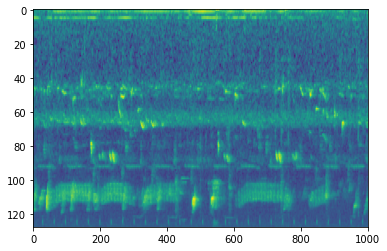

In [72]:
# sr = 32000
# w, sr = librosa.load('train_32000/train/dbff7c138.flac', sr)
# w = w[:sr*10]
        
# augment = Compose([
#     AddGaussianSNR(min_SNR=0.1, max_SNR=3.0, p=0.5)
#     ])

# w = augment(w, sr)
sr = 32000
window_size=2048
hop_size=320
mel_bins=128
fmin=50
fmax=15000

window = 'hann'
center = True
pad_mode = 'reflect'
ref = 1.0
amin = 1e-10
top_db = None

# Spectrogram extractor
spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
    win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
    freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sr, n_fft=window_size, 
    n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
    freeze_parameters=True)

# Spec augmenter
spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=4, 
    freq_drop_width=2, freq_stripes_num=2)

# x = torch.from_numpy(w)[None,:]

x = spectrogram_extractor(w[None,:])   # (batch_size, 1, time_steps, freq_bins)
x = logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)

# x = spec_augmenter(x)

print(x.shape)
x = x.transpose(2,3)
plt.imshow(x[0,0,:,:], aspect='auto'), x.shape

In [5]:
from sklearn.model_selection import StratifiedKFold

FOLDS = 5
SEED = 42

train = pd.read_csv("train_tp.csv").sort_values("recording_id")
ss = pd.read_csv("sample_submission.csv")

gr = pd.read_csv("train_grouped.csv")

train_gby = train.groupby("recording_id")[["species_id"]].first().reset_index()
train_gby = train_gby.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_gby.loc[:, 'kfold'] = -1

X = train_gby["recording_id"].values
y = train_gby["species_id"].values

kfold = StratifiedKFold(n_splits=FOLDS)
for fold, (t_idx, v_idx) in enumerate(kfold.split(X, y)):
    train_gby.loc[v_idx, "kfold"] = fold

train = train.merge(train_gby[['recording_id', 'kfold']], on="recording_id", how="left")
# print(train.kfold.value_counts())
train.to_csv("train_tp_folds.csv", index=False)
# ids = train_gby[['recording_id', 'kfold']][train_gby['kfold'] == 0]

gr[train_gby['kfold'] == 0]
# ids

FileNotFoundError: [Errno 2] No such file or directory: 'train_grouped.csv'

In [ ]:
folds = pd.read_csv('train_folds.csv')
gr[folds['kfold'] == 0]

In [ ]:
df = pd.read_csv('train_grouped.csv')

sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

for train_idx, val_idx in sss.split(X=df, y=df['species_id']):
    
    folds.append((df.loc[train_idx],df.loc[val_idx]))

In [14]:
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import math

def do_mixup(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''

    batch_size = x.size()[0]
    
    lam = torch.FloatTensor([np.random.beta(alpha, alpha) for i in range(batch_size)]).type_as(x)
    lam.requires_grad = False
    lam = lam[:,None,None,None]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]

#     y_a, y_b = y, y[index]
    
    lam = lam.view(batch_size,1)
    
    y = lam * y + (1 - lam) * y[index,:]
    
    return mixed_x, y

class AttBlock(nn.Module):
    def __init__(self, n_in, n_out):
        super(AttBlock, self).__init__()
        
        self.att = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
        self.cla = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
         
    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = torch.sigmoid(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla 

class Encoder(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num):
        
        super(Encoder, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)
        
        
        fe = 1792
        fe_features = 2048
#         fe_features = 1280
        
        self.bn1 = nn.BatchNorm1d(32)

        self.fc1 = nn.Linear(fe, fe_features, bias=True)
            
        self.att_block = AttBlock(fe_features, classes_num)
    
#         self.fe = timm.models.resnest50d_4s2x40d(pretrained=True)
        self.fe = timm.models.tf_efficientnet_b4_ns(pretrained=True)
        self.fe = nn.Sequential(*list(self.fe.children())[:-2])  
        
#         self.fc = nn.Linear(fe_features, classes_num)
        
    def forward(self, x, y=None):
        """
        Input: (batch_size, data_length)"""
        

        x = self.spectrogram_extractor(x)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        alpha=1.0
        if self.training:
            x, y = do_mixup(x,y, alpha)

        x = torch.cat([x,x,x], dim=1)
        print(x.shape)
        
        x = self.fe(x)
        print(x.shape)

        x = torch.mean(x, dim=3) # averaging across frequency dimension 
        
        stride = 1
        
#         x = F.max_pool1d(x, kernel_size=3, stride=stride, padding=1)

        x1 = F.max_pool1d(x, kernel_size=3, stride=stride, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=stride, padding=1)
        x = x1 + x2
        
        x = F.dropout(x, p=CONFIG.p, training=self.training)
        x = x.transpose(1, 2)        
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)      
        x = F.dropout(x, p=CONFIG.p, training=self.training)
        
        clipwise, att_weights, framewise = self.att_block(x)
        
        framewise = framewise.transpose(1, 2)

        # Get framewise output
        framewise = interpolate(framewise, 32)
#         framewise = pad_framewise_output(framewise, frames_num)
        
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.fc(x)        

        if self.training:
            return clipwise, y
        
        return framewise
        
# timm.list_models('*nest*')
m = Encoder(sample_rate=32000, 
            window_size=2048, 
            hop_size=320, 
            mel_bins=128, 
            fmin=50, 
            fmax=32000 // 2,
            classes_num=24)
# m.eval()

sr = 32000
w, sr = librosa.load('train_32000/train/dd0830c83.flac', sr)
w = w[:sr*10]

x = torch.from_numpy(w)

y = m(x[None,:])

y = y.transpose(1,2).detach().numpy()
plt.imshow(y[0])

TypeError: unsupported operand type(s) for *: 'Tensor' and 'NoneType'

In [31]:
df = pd.read_csv('train_tp_folds.csv')

valid_fold_id = CONFIG.valid_id

valid_df = df[df['kfold'] == valid_fold_id]
valid_df.species_id.value_counts()

23    20
17    12
5     11
15    11
11    10
21    10
18    10
16    10
14    10
13    10
1     10
0     10
10    10
8     10
7     10
4     10
6      9
3      9
20     9
22     9
12     9
19     8
9      7
2      7
Name: species_id, dtype: int64

In [33]:
model = Model.load_from_checkpoint(checkpoint_path="lightning_logs/version_1/checkpoints/val_acc=0.8139.ckpt")
model.eval()
device = 'cuda:0'
model.to(device);

In [37]:
a = torch.rand(16, 32, 1024)
b = torch.rand(16, 1024)[:,None,:]

torch.cat([a,b],dim=-1).shape

RuntimeError: Sizes of tensors must match except in dimension 2. Got 32 and 1 in dimension 1 (The offending index is 1)

In [76]:
x = torch.load('train_torch/003bec244.pt')
print(torch.chunk(x,6)[0].shape)
segments = torch.load('train_torch_segments/003bec244.pt')

sr = 22050
start = 0
end = 50 * sr

t_max = 60 * sr

t_start = np.random.randint(start, end)
t_end = t_start + 10*sr

segment_count = 132

segment_start = math.floor(t_start / t_max * segment_count)
segment_end = math.floor(t_end / t_max * segment_count)

x[segment_start:segment_end].shape, segment_start, segment_end, segments[:,segment_start:segment_end].shape

torch.Size([220500])


(torch.Size([22]), 4, 26, torch.Size([24, 22]))

torch.Size([128, 1001])


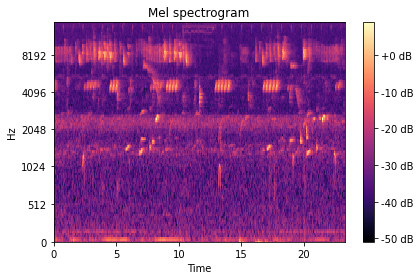

In [163]:
w, r = librosa.load('train_32000/train/003bec244.flac', 32000)
x = torch.from_numpy(w)[:32000 * 10]

window = 'hann'
center = True
pad_mode = 'reflect'
ref = 1.0
amin = 1e-10
top_db = None

sample_rate=32000 
window_size=2048
hop_size=320
mel_bins=128
fmin=50
fmax=15000
classes_num=527

spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
    n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
    freeze_parameters=True)

x = spectrogram_extractor(x.unsqueeze(0))
x = logmel_extractor(x)

# y = do_mixup(x)
# print(y.shape)
x = x.transpose(1, 3).squeeze(0).squeeze(2)

print(x.shape)

librosa.display.specshow(x.numpy(),
                         y_axis='mel', fmax=15000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()


# plt.imshow(x[0,0])

# Spec augmenter
# spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
#     freq_drop_width=8, freq_stripes_num=2)

In [208]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    
    lam = torch.FloatTensor([np.random.beta(alpha, alpha) for i in range(x.size(0))]).type_as(x)
    lam = lam[:,None]
    
    print(lam.shape)
                      
    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]

    y_a, y_b = y, y[index]
    
    lam = lam.view(batch_size,1)
    
    y = lam * y + (1 - lam) * y[index,:]
    
    return mixed_x, y

x = torch.rand(8,1,4135,128)
y = torch.rand(8,24)
mixup_data(x,y,2.0)[1].shape

torch.Size([8, 1])


RuntimeError: The size of tensor a (8) must match the size of tensor b (4135) at non-singleton dimension 2

In [49]:
# print(x)
# torch.roll(x,1,0)

In [44]:
from torch.utils import data
from torch.utils.data import DataLoader

class TestDataset(data.Dataset):

    def __init__(self, data_dir):

        self.data_dir = data_dir
        self.files = os.listdir(data_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        
        file = self.files[index]
            
        w = torch.load(self.data_dir + file)
        
        return w, file[:-3]
    
test_dataset = TestDataset('test_torch/')

batch_size = 8
num_workers = 16

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=False, 
    num_workers=num_workers, 
    pin_memory=True)


In [50]:
for W,F in tqdm(test_loader):
    
    with torch.no_grad():

        y_hat = model(W.to(device))
        
        for index, image_id in enumerate(F): 
            
            l = y_hat[index,:].tolist()
            l = list(map(lambda x: round(x,2), l))
            sub_df.loc[image_id]= l
            

# sub_df
sub_df.to_csv('submission.csv')

100%|██████████| 249/249 [02:27<00:00,  1.68it/s]


In [92]:
import csv
df = pd.read_csv('train_tp.csv')
# df.recording_id.value_counts()

grouped = df.groupby('recording_id').agg(lambda x: list(x)).reset_index()

a = []

for index, record in grouped.iterrows():
    
    a.append(len(record['t_min']))
#     for i in range(len(record['t_min'])):
#         duration = float(record['t_max'][i]) - float(record['t_min'][i])
#         a.append(duration)

np.mean(a)
# d.to_csv('train_grouped.csv', index=False)
# for i in d.species_id:
#     print(i.split('+'))
# d.species_id.str.len().sort_values()
# d[d.species_id > 24]

1.0742049469964665

In [47]:
import math

tensor_dict = {}

segment_count = 132

for index, row in df.iterrows():
    
    rec_id = row['recording_id']
    
    if not rec_id in tensor_dict:
        tensor_dict[rec_id] = torch.zeros(24,segment_count)
    
    start_segment = math.floor(float(row['t_min']) / 60.0 * segment_count - 1)
    end_segment = math.floor(float(row['t_max']) / 60.0 * segment_count - 1)
    
    class_id = row['species_id']
    
    tensor_dict[rec_id][class_id,start_segment:end_segment] = 1
    
#     print(start_segment, float(row['t_min']))
    

for k, v in tensor_dict.items():
    torch.save(v, 'train_torch_segments/' + k + '.pt')
    

In [50]:
len(os.listdir('train_torch')), len(tensor_dict)

(1133, 1132)

In [52]:
df.f_min.min()

93.75

In [210]:
df = pd.read_csv('train_grouped.csv')

train, test = train_test_split(df, test_size=0.2)
    
train

,recording_id,species_id
366,533ae3f85,18
499,6eb03e9ca,7
838,bd97b0335,11
964,d86155abb,1
800,b4a3fb69c,17
...,...,...
46,09a946316,23
602,83028db30,11
240,3458e20b8,10
519,7341161bd,17


In [233]:
m = nn.Sigmoid()
# loss = nn.BCELoss()
input = torch.randn(1,1, requires_grad=True)
target = torch.empty(1,1).random_(2)
output = F.binary_cross_entropy(m(input), target)
target, m(input), output
# output.backward()

(tensor([[1.]]),
 tensor([[0.5811]], grad_fn=<SigmoidBackward>),
 tensor(0.5429, grad_fn=<BinaryCrossEntropyBackward>))

In [3]:
pd.read_csv('sample_submission.csv')

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1988,ff973e852,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1989,ffa5cf6d6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1990,ffa88cbb8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
